In [52]:
import sys
path = '/gpfs/commons/groups/gursoy_lab/mstoll/'
sys.path.append(path)

import numpy as np
import pandas as pd
import pickle
import time
import os


from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight

from tqdm.auto import tqdm
import statsmodels.api as sm
from multiprocessing import Pool

from codes.models.utils import number_tests
from codes.models.data_form.DataForm import DataTransfo_1SNP
from sklearn.model_selection import train_test_split


from codes.models.metrics import calculate_roc_auc
import matplotlib.pyplot as plt
from codes.models.Decision_tree.utils import get_indice, get_name

In [ ]:
### framework constants:
model_type = 'decision_tree'
model_version = 'gradient_boosting'
test_name = '1_test_train_transfo_V1'
option = 'pairwise'
tryout = True # True if we are ding a tryout, False otherwise 
### data constants:
### data constants:
CHR = 6
SNP = 'rs12203592'
pheno_method = 'Paul' # Paul, Abby
ld = 'no'
rollup_depth = 4
binary_classes = True #nb of classes related to an SNP (here 0 or 1)
vocab_size = None # to be defined with data
padding_token = 0
prop_train_test = 0.8
load_data = False
save_data = True
remove_none = True
decorelate = False
equalize_label = False
threshold_corr = 0.9
threshold_rare = 50
remove_rare = 'all' # None, 'all', 'one_class'
compute_features = True
padding = False
list_env_features = ['age', 'sex']
list_pheno_ids = None #list(np.load(f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/phewas/list_associations_snps/{SNP}_paul.npy'))

### data format

batch_size = 20
data_share = 1

##### model constants


##### training constants


In [ ]:
"""
path = '/gpfs/commons/groups/gursoy_lab/mstoll/codes/'

#check test name
model_dir = path + f'logs/SNPS/{str(CHR)}/{SNP}/{model_type}/{model_version}/{pheno_method}'
os.makedirs(model_dir, exist_ok=True)
#check number tests
number_test = number_tests(model_dir)
test_name_with_infos = str(number_test) + '_' + test_name + 'tryout'*tryout
test_dir = f'{model_dir}/{test_name_with_infos}/'
log_data_dir = f'{test_dir}/data/'
log_res_dir = f'{test_dir}/res/'
log_slurm_outputs_dir = f'{test_dir}/Slurm/Outputs/'
log_slurm_errors_dir = f'{test_dir}/Slurm/Errors/'

os.makedirs(log_data_dir)
os.makedirs(log_res_dir)
os.makedirs(log_slurm_outputs_dir)
os.makedirs(log_slurm_errors_dir)


log_data_path_pickle = f'{test_dir}/data/{test_name}.pkl'


log_res_path_pickle = f'{test_dir}/res/{test_name}_{option}.pkl'
log_slurm_outputs_path = f'{test_dir}/Slurm/Outputs/{test_name}_{option}.pth'
log_slurm_error_path = f'{test_dir}/Slurm/Errors/{test_name}_{option}.pth'

   
# Redirect  output to a file
sys.stdout = open(log_slurm_outputs_path, 'w')
sys.stderr = open(log_slurm_error_path, 'w')

"""

In [ ]:
dataT = DataTransfo_1SNP(SNP=SNP,
                         CHR=CHR,
                         method=pheno_method,
                         padding=padding,  
                         pad_token=padding_token, 
                         load_data=load_data, 
                         save_data=save_data, 
                         compute_features=compute_features,
                         prop_train_test=prop_train_test,
                         remove_none=remove_none,
                         equalize_label=equalize_label,
                         rollup_depth=rollup_depth,
                         decorelate=decorelate,
                         threshold_corr=threshold_corr,
                         threshold_rare=threshold_rare,
                         remove_rare=remove_rare, 
                         list_env_features=list_env_features,
                         data_share=data_share,
                         list_pheno_ids=list_pheno_ids,
                         binary_classes=binary_classes, 
                         ld = ld)
#patient_list = dataT.get_patientlist()

In [ ]:
data, labels_patients, indices_env, name_envs, eids = dataT.get_tree_data(with_env=False, load_possible=True, only_relevant=False)

In [ ]:
frequencies_ini = np.sum(data, axis=0)

In [10]:
equalized = True
interest = False
keep = True
scaled = False
remove = False

if interest:
    data_use, labels_use = data[:nb_patients_interest, :-1], labels_patients[:nb_patients_interest]
else:
    data_use, labels_use = data, labels_patients
if remove:
    eids_remove = np.load('/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/UKBB/eids_remove_1.npy')
    indices_eids = (1-np.isin(eids, eids_remove)).astype(bool)
    eids_use = eids[indices_eids]
    data_use = data_use[indices_eids]
    labels_use = labels_use[indices_eids]
    
if equalized:
    pheno, labels = DataTransfo_1SNP.equalize_label(data=data_use, labels = labels_use)
else:
    pheno, labels = data_use, labels_use


In [11]:
diseases_patients_train, diseases_patients_test, label_patients_train, label_patients_test = train_test_split(pheno, labels, test_size = 1-prop_train_test, random_state=42)

In [48]:
indices_keep = (frequencies_ini > 0) & (frequencies_ini > 2000)
#indices_keep = shaps!=0
diseases_patients_train_keep = diseases_patients_train[:,indices_keep]
diseases_patients_test_keep = diseases_patients_test[:, indices_keep]
phenos_keep = np.arange(diseases_patients_train.shape[1])[indices_keep]
if keep:
    diseases_patients_train_model = diseases_patients_train_keep
    diseases_patients_test_model = diseases_patients_test_keep
else:
    diseases_patients_train_model = diseases_patients_train
    diseases_patients_test_model = diseases_patients_test



In [19]:
def logreg(pheno_data, label_data, disp=False):
    try:
        logit_model = sm.Logit(label_data, pheno_data)
        result = logit_model.fit(disp=disp)
        p_value = result.pvalues[0]
        coeff = result.params[0]
        return p_value, coeff, result
    except:
        return None, None, None


In [20]:
nb_diseases = diseases_patients_train_model.shape[1]

In [21]:
num_processes = 10
option = 'pairwise'
pheno_data_train = diseases_patients_train_model
label_data_train = label_patients_train

In [22]:
pheno_indexs = np.arange(nb_diseases)
pheno_indexs_splits = np.array_split(pheno_indexs, nb_diseases // num_processes )

## Open tensor board writer
"""
output_file = log_slurm_outputs_path
with open(output_file, 'w') as file:
    file.truncate()
    file.close()
"""
start_time_cell = time.time()
p_values = []
coeffs = []
models = []
if option=='pairwise':
    p_values = np.zeros(nb_diseases)
    coeffs = np.zeros(nb_diseases)
    label_data_train = [np.array(label_data_train) for _ in range(num_processes)]
    for batch_phenos_index in tqdm(pheno_indexs_splits, desc="batch num"):
        start_time =  time.time()

        if len(batch_phenos_index) == num_processes:
            pool = Pool(processes=num_processes)
            pheno_data_train_batch = [pheno_data_train[:, pheno_index] for pheno_index in batch_phenos_index]



            results = pool.starmap(logreg, zip(pheno_data_train_batch, label_data_train))
            # Fermez le pool de processus
            pool.close()
            pool.join()
            p_values[batch_phenos_index]= np.array([result[0] for result in results])
            coeffs[batch_phenos_index] = np.array([result[1] for result in results])
            for result in results:
                models.append(result[2])

        else:
            for pheno_index in batch_phenos_index:
                pheno_data_train_batch = pheno_data_train[:, pheno_index]
                p_value, coeff, model = logreg(pheno_data_train_batch, label_data_train)
                p_values[pheno_index] = p_value
                coeffs[pheno_index] = coeff
                models.append(model)
        print(f'batch finished in {time.time() - start_time} s')
else:
    p_value, coeff, model = logreg(pheno_data_train, label_data_train, disp=True)
    models.append(model)
    p_values.append(p_value)
    coeffs.append(coeff)
print(f'program over in {time.time()-start_time_cell}s')

res_dic = {'option' : option,
    'models' : models,
    'p_values' : p_values,
    'coeffs' : coeffs
}

#tree_data_dic = {'pheno_data_train' : pheno_data_train, 'pheno_data_test' : pheno_data_test, 'label_data_train' : label_data_train, 'label_data_test':label_data_test}
"""
with open(log_res_path_pickle, 'wb') as file:
    pickle.dump(res_dic, file)
print('Res saved to %s' % log_res_path_pickle)

with open(log_data_path_pickle, 'wb') as file:
    pickle.dump(tree_data_dic, file)
print('Data saved to %s' % log_data_path_pickle)

"""

batch num:   0%|          | 0/52 [00:00<?, ?it/s]

batch finished in 0.05694222450256348 s
batch finished in 0.01714468002319336 s
batch finished in 0.016806840896606445 s
batch finished in 0.017626523971557617 s
batch finished in 7.29543399810791 s
batch finished in 7.318671703338623 s
batch finished in 7.268195867538452 s
batch finished in 7.380559682846069 s
batch finished in 7.262699127197266 s
batch finished in 7.278621673583984 s
batch finished in 7.4124462604522705 s
batch finished in 7.371567726135254 s
batch finished in 7.286245584487915 s
batch finished in 7.394737482070923 s
batch finished in 7.33593225479126 s
batch finished in 7.30226731300354 s
batch finished in 7.302696943283081 s
batch finished in 7.31318473815918 s
batch finished in 7.403692960739136 s
batch finished in 7.25386905670166 s
batch finished in 7.327426910400391 s
batch finished in 7.249215841293335 s
batch finished in 7.322502851486206 s
batch finished in 7.409335374832153 s
batch finished in 7.2682905197143555 s
batch finished in 7.356097459793091 s
batch

"\nwith open(log_res_path_pickle, 'wb') as file:\n    pickle.dump(res_dic, file)\nprint('Res saved to %s' % log_res_path_pickle)\n\nwith open(log_data_path_pickle, 'wb') as file:\n    pickle.dump(tree_data_dic, file)\nprint('Data saved to %s' % log_data_path_pickle)\n\n"

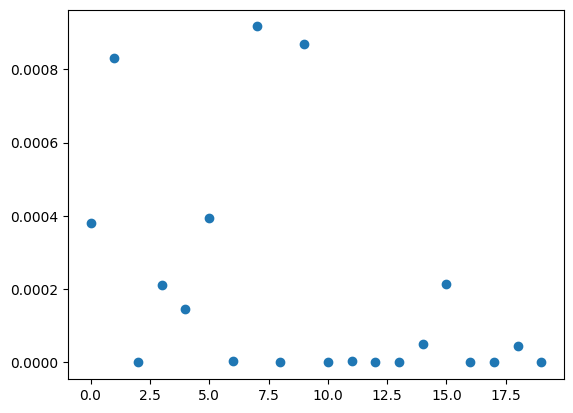

In [41]:
plt.plot(p_values[p_values < 0.001], 'o')

In [61]:
indices_associtated = np.where(p_values<0.0000001)[0]
id_pheno_associated = phenos_keep[indices_associtated]

In [62]:
get_name(dataT, id_pheno_associated)

['Actinic keratosis',
 'Melanocytic nevus',
 'Disorder of skin of neck',
 'Malignant neoplasm of soft tissue',
 'Primary malignant neoplasm of head',
 'Melanocytic tumor of skin',
 'Lesion of skin of face']

In [ ]:
class_weights = compute_sample_weight(class_weight='balanced', y=label_patients_train)

# Adjust the input data with the square root of weights
sqrt_weights = np.sqrt(class_weights)
pheno_data_train_weighted = diseases_patients_train * sqrt_weights[:, np.newaxis]
column_one_train = np.ones((diseases_patients_train.shape[0],1 ))
column_one_test = np.ones((diseases_patients_test.shape[0],1 ))

pheno_data_train_weighted_with_constant=  np.concatenate([column_one_train, pheno_data_train_weighted], axis = 1)

In [ ]:
pheno_data_train_weighted = diseases_patients_train * sqrt_weights[:, np.newaxis]


In [ ]:
logit_model = sm.Logit(label_patients_train, pheno_data_train_weighted_with_constant)
result = logit_model.fit(method='bfgs', disp=True)

In [ ]:
pheno_data_train_with_constant =  np.concatenate([column_one_train, diseases_patients_train], axis = 1)
pheno_data_test_with_constant =  np.concatenate([column_one_test, diseases_patients_test], axis = 1)

In [ ]:
### visualisation des donnes avec df
proba_test = result.predict(pheno_data_test_with_constant)
proba_train = result.predict(pheno_data_train_weighted_with_constant)

In [ ]:
labels_pred_test = (proba_test > 0.5).astype(int)
nb_positive_test = np.sum(labels_pred_test==0)
nb_negative_test = np.sum(labels_pred_test==1)
labels_pred_train = (proba_train > 0.5).astype(int)
nb_positive_train = np.sum(labels_pred_train==0)
nb_negative_train = np.sum(labels_pred_train==1)

In [ ]:
TP_test = np.sum((label_patients_test==0 )& (labels_pred_test == 0)) / nb_positive_test
FP_test = np.sum((label_patients_test==1 )& (labels_pred_test == 0)) / nb_positive_test
TN_test = np.sum((label_patients_test==1 )& (labels_pred_test == 1)) / nb_negative_test
FN_test = np.sum((label_patients_test== 0)& (labels_pred_test == 1)) / nb_negative_test

TP_train = np.sum((label_patients_train==0 )& (labels_pred_train == 0)) / nb_positive_train
FP_train = np.sum((label_patients_train==1 )& (labels_pred_train == 0)) / nb_positive_train
TN_train = np.sum((label_patients_train==1 )& (labels_pred_train == 1)) / nb_negative_train
FN_train = np.sum((label_patients_train== 0)& (labels_pred_train == 1)) / nb_negative_train


auc_test = calculate_roc_auc(label_patients_test, proba_test)
auc_train = calculate_roc_auc(label_patients_train, proba_train)

In [ ]:
nb_zeros = np.sum(label_patients_test==0)

In [ ]:
nb_zeros

In [ ]:
(labels_pred_test==0).sum()

In [ ]:
print(f'{TP_test=}') 
print(f'{FP_test=}')
print(f'{TN_test=}')
print(f'{FN_test=}')
print(f'{TP_train=}') 
print(f'{FP_train=}')
print(f'{TN_train=}')
print(f'{FN_train=}')

print(f'{auc_test=}')
print(f'{auc_train=}')

In [ ]:
print(f'{TP_test=}') 
print(f'{FP_test=}')
print(f'{TN_test=}')
print(f'{FN_test=}')
print(f'{TP_train=}') 
print(f'{FP_train=}')
print(f'{TN_train=}')
print(f'{FN_train=}')

print(f'{auc_test=}')
print(f'{auc_train=}')

In [ ]:
np.std(proba_train)

In [ ]:
np.mean(proba_train[label_data_train==0])